<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Shayan Salehi
### Student Number : 99105561
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
from torch.optim import Adam
from copy import deepcopy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [4]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([transforms.Resize(28), transforms.ToTensor(), transforms.Normalize(mean=[0.1307], std=[0.3081])])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [5]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [6]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(dataset=train_data, batch_size=16, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=16, num_workers=4, shuffle=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1acQve-TOYd6wYtogpHCblhoDZt9jWQdf/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [7]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):

    def __init__(self):

        super().__init__()

        self.first = nn.Sequential(nn.Conv2d(1, 16, 3, padding='same'), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2, stride=2))

        self.second = nn.Sequential(nn.Conv2d(16, 16, 3, padding='same'), nn.BatchNorm2d(16), nn.ReLU(), nn.Conv2d(16, 16, 3, padding='same'), nn.BatchNorm2d(16), nn.ReLU())

        self.third = nn.Sequential(nn.MaxPool2d(2, stride=2), nn.Conv2d(16, 64, 3, padding='same'), nn.BatchNorm2d(64), nn.ReLU())

        self.forth = nn.Sequential(nn.Conv2d(64, 64, 3, padding='same'), nn.BatchNorm2d(64), nn.ReLU(), nn.Conv2d(64, 64, 3, padding='same'), nn.BatchNorm2d(64), nn.ReLU())

        self.fifth = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(64, 10), nn.ReLU())

    def forward(self, x):

        res1 = self.first(x)
        res2 = self.second(res1)
        res3 = self.third(res1 + res2)
        res4 = self.forth(res3)
        return self.fifth(res3 + res4)

# Train Model (30 Points)

In [8]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.01)

In [9]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20

pref_md, pref_ac = None, 0
list_of_losses, list_of_accuracies = list(), list()
for epoch in range(num_epochs):
    sum, cr, rl = 0, 0, 0
    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        pre_tr, rl = out.argmax(dim=1), loss.item()
        sum, cr = sum + len(pre_tr), cr + (pre_tr == labels).sum().item()

    list_of_losses.append(rl)
    list_of_accuracies.append(cr / sum)
    result = "In epoch of " + str(epoch) + ":\n" + "accuracy: " + str(list_of_accuracies[-1]) + "\nloss: " + str(list_of_losses[-1])
    print(result)

    with torch.no_grad():
        for images, labels in val_loader:
           images, labels = images.to(device), labels.to(device)
           out = model(images)
           pre_tr = out.argmax(dim=1)
           sum, cr = sum + len(pre_tr), cr + (pre_tr == labels).sum().item()
        if (cr / sum) > pref_ac: pref_ac, pref_md = (cr / sum), deepcopy(model)

In epoch of 0:
accuracy: 0.69732
loss: 0.2581886351108551
In epoch of 1:
accuracy: 0.9072
loss: 0.3403541147708893
In epoch of 2:
accuracy: 0.91138
loss: 0.32227134704589844
In epoch of 3:
accuracy: 0.91282
loss: 0.35675662755966187
In epoch of 4:
accuracy: 0.91648
loss: 0.4343225955963135
In epoch of 5:
accuracy: 0.91832
loss: 0.4977481961250305
In epoch of 6:
accuracy: 0.91816
loss: 0.2959005534648895
In epoch of 7:
accuracy: 0.91924
loss: 0.3303353190422058
In epoch of 8:
accuracy: 0.92138
loss: 0.3258202075958252
In epoch of 9:
accuracy: 0.9199
loss: 0.09135586768388748
In epoch of 10:
accuracy: 0.92126
loss: 0.301938533782959
In epoch of 11:
accuracy: 0.92028
loss: 0.11384609341621399
In epoch of 12:
accuracy: 0.9206
loss: 0.24211318790912628
In epoch of 13:
accuracy: 0.92036
loss: 0.4234364926815033
In epoch of 14:
accuracy: 0.9201
loss: 0.5770555138587952
In epoch of 15:
accuracy: 0.9215
loss: 0.22123569250106812
In epoch of 16:
accuracy: 0.92296
loss: 0.47635969519615173
In epo

Text(0.5, 0, 'Epoch')

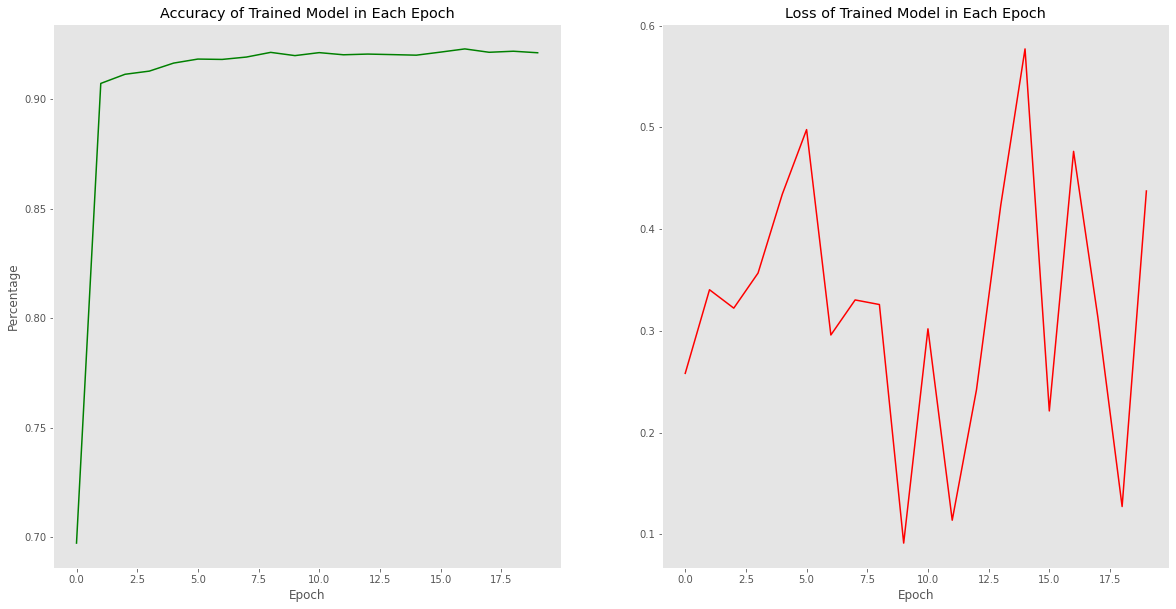

In [10]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

figure, axis = plt.subplots(1, 2, figsize=(20, 10))
axis[0].plot(list_of_accuracies, color = "green")
axis[0].set_title("Accuracy of Trained Model in Each Epoch")
axis[0].grid(False)
axis[0].set_xlabel("Epoch")
axis[0].set_ylabel("Percentage")
axis[1].plot(list_of_losses, color = "red")
axis[1].set_title("Loss of Trained Model in Each Epoch")
axis[1].grid(False)
axis[1].set_xlabel("Epoch")


# Test Model (20 Points)

10000
The value of loss is: 0.20951830416917802
The value of accuracy is: 0.9542


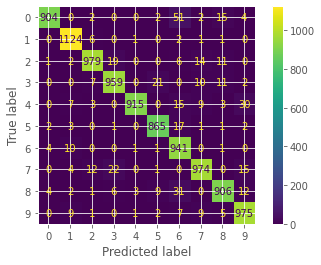

In [29]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
import sklearn.metrics

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

y_true, y_predicted = list(), list()

with torch.no_grad():
    sum, cr, num = 0, 0, 0
    pref_md.eval()
    for index, (ins, trg) in enumerate(test_loader):
      ins, trg = ins.to(device), trg.to(device)
      out = pref_md(ins)
      pr_trg, num, sum = out.argmax(dim=1), num + ins.shape[0], sum + criterion(out, trg).item() * ins.shape[0]
      cr = cr + (pr_trg == trg).sum().item()
      y_true.extend(trg.cpu())
      y_predicted.extend(pr_trg.cpu())

    result = "The value of loss is: " + str(sum / num) + "\nThe value of accuracy is: " + str(cr / num)
    print(result)

confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=sklearn.metrics.confusion_matrix(y_true, y_predicted))
confusion_matrix.plot()